# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: A. Gramfort, H. Janati, M. Massias

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal coordinate descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 22nd of november at noon**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [53]:
# Change here using YOUR first and last names
fn1 = "bryan"
ln1 = "chen"
fn2 = "alice"
ln2 = "devilder"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_chen_bryan_and_devilder_alice.ipynb


In [54]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

import time

In [55]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

C:\Users\alice\AppData\Local\Temp\ipykernel_26332\428856815.py:4: DeprecationWarning: Please use `toeplitz` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import toeplitz


## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$


<div class="alert alert-success">
    <b>QUESTION 1:</b> We ask you to code
     <ul>
         <li>cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$</li>
         <li>greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.
</li>
    </ul>
</div>

**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [56]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [57]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j]
        w[j] += A[:, j].dot(residuals) / lips_const[j]
        # update residuals:
        residuals += A[:, j] * (old_w_j - w[j])
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(np.abs(gradient))
        old_w_j = w[j]
        w[j] -= gradient[j] / lips_const[j]
        # update gradient:
        gradient += gram[:, j] * (w[j] - old_w_j)
        # END TODO
        
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Compute a precise minimum with your favorite solver</li>
         <li>Compare the performance of cyclic and greedy CD as function of iterations.</li>
         <li>From a practical point of view, could you use greedy CD for L2 regularized logistic regression? to solve OLS, but with 100,000 features? Explain your answers.</li>
    </ul>
</div>

**Remark:** You will do the plots using the number of iterations on the x-axis and not time as your code is likely to be slow unless you use [numba](https://numba.pydata.org/).

In [58]:
def loss_linreg(w):
    """Least-squares loss"""
    return np.linalg.norm(A @ w - b, ord=2)**2/2

def grad_linreg(w):
    """Leas-squares gradient"""
    return A.T @ (A @ w - b)

### 1. Compute a precise minimum with your favorite solver

In [59]:
# compute precise minimum with your favorite solver

from numpy.linalg import lstsq

w_min, _, _, _ = lstsq(A, b, rcond=None)
min_lstsq = loss_linreg(w_min)

# print(w_min)
print(f"Precise minimum with favorite solver (lstsq) = {min_lstsq} \n")
print(f"Gradient norm at w_min = {norm(grad_linreg(w_min))}")

Precise minimum with favorite solver (lstsq) = 466.3849765337658 

Gradient norm at w_min = 5.133562688586661e-11


### 2. Compare the performance of cyclic and greedy CD as function of iterations

In [69]:
n_iter = 3000

start_time = time.time()
w_cyclic, all_objs_cyclic = cyclic_cd(A, b, n_iter)
print(f"Duration of cyclic coordinate descent = {time.time() - start_time:.3f} seconds \n")
start_time = time.time()
w_greedy, all_objs_greedy = greedy_cd(A, b, n_iter)
print(f"Duration of greedy coordinate descent = {time.time() - start_time:.3f} seconds \n")

print(f"Precise minimum with cyclic coordinate descent = {loss_linreg(w_cyclic)} ")
print(f"Gradient norm at w_cyclic = {norm(grad_linreg(w_cyclic))} \n")
print(f"Precise minimum with greedy coordinate descent = {loss_linreg(w_greedy)}")
print(f"Gradient norm at w_greedy = {norm(grad_linreg(w_greedy))}")

Duration of cyclic coordinate descent = 0.025 seconds 

Duration of greedy coordinate descent = 0.037 seconds 

Precise minimum with cyclic coordinate descent = 466.3849765339347 
Gradient norm at w_cyclic = 0.00030884372297994647 

Precise minimum with greedy coordinate descent = 466.384976533766
Gradient norm at w_greedy = 1.0335130410048501e-05


Small remark: We notice that the greedy coordinate descent gives a slightly better solution than the cyclic one because the gradient norm is smaller.

In [61]:
print(min_lstsq)

466.3849765337658


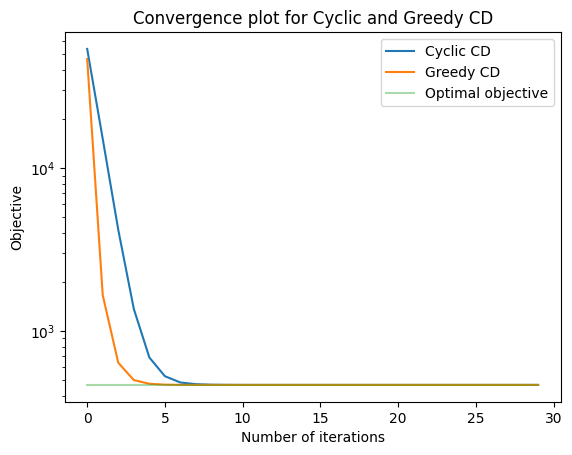

In [62]:
list_opt_min = [min_lstsq for i in range(min(len(all_objs_greedy), 100))]

plt.plot(all_objs_cyclic, label='Cyclic CD')
plt.plot(all_objs_greedy, label='Greedy CD')
plt.plot(list_opt_min, label='Optimal objective', alpha=0.4)
plt.xlabel('Number of iterations')
plt.ylabel('Objective')
plt.title('Convergence plot for Cyclic and Greedy CD')
plt.yscale('log')
plt.legend()
plt.show()

**Comments:**

We can observe that the Greedy Coordinate Descent converges faster than the Cyclic Coordinate Descent. This is due to the fact that the Greedy CD selects the coordinate that has the largest gradient in magnitude, which allows it to converge faster. The Greedy CD reaches the minimum in 5 iterations, while the Cyclic CD reaches it in 7 iterations.

### 3. From a practical point of view, could you use greedy CD for L2 regularized logistic regression? to solve OLS, but with 100,000 features? Explain your answers

* **Greedy CD for L2-regularized logistic regression:**

From a practical standpoint, using greedy coordinate descent (CD) for L2-regularized logistic regression is not ideal. Greedy CD involves selecting and updating the coordinate that provides the greatest decrease in the objective function at each iteration. While coordinate descent can be effective for problems with certain structures, such as L1 regularization where updates can be computed efficiently, it becomes less practical for L2-regularized logistic regression with a large number of features.

In L2-regularized logistic regression, the objective function is smooth but not separable across coordinates due to the logistic loss. Each coordinate update requires computing gradients that depend on all data points, which can be computationally expensive. With 100,000 features, the cost per iteration becomes significant, and the number of iterations required to converge can be large. Moreover, greedy selection adds overhead because it requires evaluating the potential improvement for each coordinate, increasing computational complexity.

* **Greedy CD for OLS with 100,000 features:**

Similarly, using coordinate descent for Ordinary Least Squares (OLS) with 100,000 features is not practical. OLS has a quadratic loss function, and while coordinate descent can be applied, each coordinate update involves computing the residuals and updating them, which can be costly when the number of features is large. The benefit of coordinate descent diminishes in high-dimensional settings because the per-iteration cost and the total number of iterations increase.

In practice, for large-scale problems with many features, optimization methods like stochastic gradient descent (SGD) or mini-batch gradient descent are more suitable. These methods scale better with the number of features and data points, and they can exploit the smoothness and convexity of the objective function more effectively than coordinate descent in such settings.

**Answer:**

From a practical perspective, using greedy coordinate descent for L2-regularized logistic regression or OLS with 100,000 features is not advisable due to computational inefficiency. The high dimensionality makes coordinate updates expensive and the overhead of greedy selection substantial, making other optimization methods more suitable for such large-scale problems.

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$

<div class="alert alert-success">
    <b>QUESTION 3:</b><br/>
    Assuming uniqueness of the solution, show that: 
</div>

$$
\lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0
, \text{where }\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}
$$

**HINT:** You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$
\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert (w_1)  \times \dots \times \partial \vert \cdot \vert (w_p) 
$$

where $\times$ is the Cartesian product between sets,
and 
$$ 
\partial \vert \cdot \vert (w_j) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

**Answer:**

To show that $\hat{w} = 0_p$ is the unique minimizer if and only if $\lambda \geq \lambda_{\max} := \frac{1}{2}\|X^\top y\|_\infty$, we use subgradient optimality conditions for convex functions.

Consider the optimization problem:

$$
\hat{w} \in \operatorname*{arg\,min}_{w \in \mathbb{R}^p} \left[ f(w) + \lambda \|w\|_1 \right],
$$

where

$$
f(w) = \sum_{i=1}^{n} \log\left(1 + e^{-y_i w^\top x_i}\right).
$$

The gradient of $f(w)$ with respect to $w$ is:

$$
\nabla f(w) = -\sum_{i=1}^{n} y_i x_i \frac{e^{-y_i w^\top x_i}}{1 + e^{-y_i w^\top x_i}} = -\sum_{i=1}^{n} y_i x_i \sigma(-y_i w^\top x_i),
$$

where $\sigma(z) = \frac{1}{1 + e^{-z}}$ is the sigmoid function.

At $w = 0_p$, since $\sigma(0) = \frac{1}{2}$, we have:

$$
\begin{align*}
\nabla f(0_p) &= -\sum_{i=1}^{n} y_i x_i \left( \frac{1}{2} \right) \\
&= -\frac{1}{2} X^\top y.
\end{align*}
$$

The subdifferential of the $L_1$-norm at $w = 0_p$ is:

$$
\partial \|w\|_1 \big|_{w=0_p} = [-1, 1]^p.
$$

The necessary and sufficient condition for $w = 0_p$ to be a minimizer is:

$$
0 \in \nabla f(0_p) + \lambda \, \partial \|w\|_1 \big|_{w=0_p}.
$$

Substituting the computed gradient and subdifferential, we get:

$$
0 \in -\frac{1}{2} X^\top y + \lambda s, \quad \text{where } s \in [-1, 1]^p.
$$

This implies:

$$
\frac{1}{2} X^\top y \in \lambda s, \quad s \in [-1, 1]^p.
$$

Therefore, for each component $j$:

$$
\left| \frac{1}{2} (X^\top y)_j \right| \leq \lambda.
$$

This leads to the condition:

$$
\lambda \geq \frac{1}{2} \| X^\top y \|_\infty = \lambda_{\max}.
$$

Hence, if $\lambda \geq \lambda_{\max}$, then $w = 0_p$ satisfies the optimality condition and is the unique minimizer. Conversely, if $\hat{w} = 0_p$ is the unique minimizer, the optimality condition must hold, implying $\lambda \geq \lambda_{\max}$.

Therefore, we conclude that:

$$
\lambda \geq \lambda_{\max} \quad \Leftrightarrow \quad \hat{w} = 0_p.
$$

<div class="alert alert-success">
    <b>QUESTION 4:</b><br/>
    Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.
</div>

**Answer:**

To show that for sparse logistic regression, the coordinate-wise Lipschitz constant of the smooth term $\gamma_j$ can be taken equal to $\| X_j \|^2 / 4$, where $X_j$ denotes the $j$-th column of $X$, we proceed as follows.

The smooth part of the logistic regression objective function is:

$$
f(w) = \sum_{i=1}^{n} \log\left(1 + e^{- y_i w^\top x_i}\right).
$$

We are interested in finding the Lipschitz constant $\gamma_j$ for the gradient component $\frac{\partial f}{\partial w_j}(w)$ with respect to $w_j$. Specifically, we need to find $\gamma_j$ such that for all $w, w'$:

$$
\left| \frac{\partial f}{\partial w_j}(w) - \frac{\partial f}{\partial w_j}(w') \right| \leq \gamma_j \left| w_j - w_j' \right|.
$$

First, we compute the partial derivative of $f(w)$ with respect to $w_j$:

$$
\frac{\partial f}{\partial w_j}(w) = \sum_{i=1}^{n} -y_i x_{ij} \sigma(- y_i w^\top x_i),
$$

where $\sigma(t) = \frac{1}{1 + e^{-t}}$ is the sigmoid function, and $x_{ij}$ is the $j$-th element of the vector $x_i$.

Next, we compute the second derivative with respect to $w_j$:

$$
\frac{\partial^2 f}{\partial w_j^2}(w) = \sum_{i=1}^{n} x_{ij}^2 \sigma(- y_i w^\top x_i) \left(1 - \sigma(- y_i w^\top x_i)\right).
$$

Note that for any real number $t$, the product $\sigma(t)(1 - \sigma(t))$ attains its maximum value of $\frac{1}{4}$ when $t = 0$, and is always non-negative and less than or equal to $\frac{1}{4}$:

$$
0 \leq \sigma(t)(1 - \sigma(t)) \leq \frac{1}{4}.
$$

Therefore, we have:

$$
\frac{\partial^2 f}{\partial w_j^2}(w) \leq \frac{1}{4} \sum_{i=1}^{n} x_{ij}^2 = \frac{1}{4} \| X_j \|^2,
$$

where $\| X_j \|^2 = \sum_{i=1}^{n} x_{ij}^2$ is the squared Euclidean norm of the $j$-th column of $X$.

Since the second derivative provides an upper bound on the rate of change of the gradient, the Lipschitz constant $\gamma_j$ for the gradient component $\frac{\partial f}{\partial w_j}(w)$ can be taken as $\gamma_j = \frac{1}{4} \| X_j \|^2$.

**Answer:**

For sparse logistic regression, the coordinate-wise Lipschitz constant of the smooth term $\gamma_j$ can be taken equal to $\| X_j \|^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.


<div class="alert alert-success">
    <b>QUESTION 5:</b><br/>
    Code cyclic proximal coordinate descent for sparse Logistic regression:
</div>

**WARNING**: the Lasso means linear regression (quadratic fitting term) with L1 penalty. Sparse logistic regression means logistic regression with L1 penalty.

In [63]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 20.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    
    # TODO
    # lips_const = 
    # END TODO
    
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            # grad_j = 
            # w[j] = soft_thresh(1, 2)
            
            # if old_w_j != w[j]:
                # Xw += 
            #END TODO
            
        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
    
    return w, all_objs

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

In [64]:
from sklearn.datasets import fetch_openml

leuk = fetch_openml("leukemia")

X = np.asfortranarray(leuk.data)
y = np.ones(leuk.target.shape)
y[leuk.target == leuk.target[0]] = -1.

c:\Users\alice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\datasets\_openml.py:311: UserWarning: Multiple active versions of the dataset matching the name leukemia exist. Versions may be fundamentally different, returning version 1.
  warn(
c:\Users\alice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


KeyboardInterrupt: 

In [ ]:
print(X.shape)

lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

(72, 7129)


<div class="alert alert-success">
    <b>QUESTION 6:</b> Code
    <ul>
        <li>a simple proximal gradient solver for the Lasso</li>
        <li>a prox CD solver for the Lasso and compare them on this dataset.</li>
    </ul>
</div>

**Remark:** Do the plots in terms of epochs, not updates (to be fair to CD).